# Polynomial SVC

# Problems Identification:
This project involves the implementation of efficient and effective polynomial SVC on MNIST data set. The MNIST data comprises of digital images of several digits ranging from 0 to 9. Each image is 28 x 28 pixels. Thus, the data set has 10 levels of classes.

These are the needed packages:

In [1]:
import winsound
import matplotlib.pyplot as plt
plt.rcdefaults()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC, LinearSVC
from mnist import MNIST
from time import time
import matplotlib.pyplot as plt
plt.rcdefaults()
from IPython.display import display
from pylab import subplot
import pandas as pd
import numpy as np
import os
import random as rand

Load the dataset, having downloaded it from Yann. The train data set comprises of 60,000 samples and the test data set has 10,000 samples.

In [2]:
__mndata__ = MNIST(os.getcwd() +'\\image')
__train_image__, __train_label__ = __mndata__.load_training() #train & train_label
__test_image__, __test_label__ = __mndata__.load_testing() #test & test_label

The train and test images were reshaped to 784 dimension long, which translate to one feature for each pixel in the image.

### Visualization:
Visualizing a random 28 by 28 image.

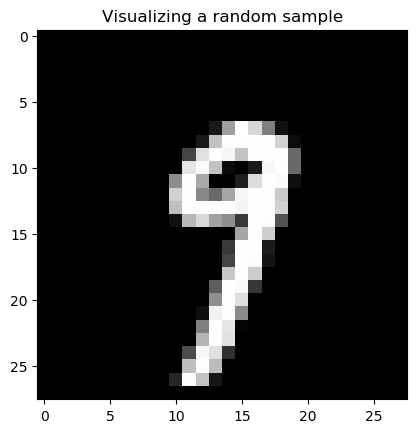

In [4]:
plt.imshow(np.reshape(__train_image__[rand.randint(1,1000)], [28,28]), cmap='Greys_r'); plt.title('Visualizing a random sample'); plt.show()

### Implementation functions:

In [38]:
class Utility:
    """This class warehouses the data and other general functions"""
    def __init__(self):
        self.train = np.asarray([np.reshape(x, (784)) for x in __train_image__]).astype(
            'float64')  # change train_image to numpy array #784 means 28 by 28 pixel
        self.train_label = np.asarray(__train_label__)
        self.test = np.asarray([np.reshape(x, (784)) for x in __test_image__]).astype(
            'float64')  # change test_image to numpy array
        self.test_label = np.asarray(__test_label__)
        self.n_class = list(range(10))  # class labels

    def confusionMatrix(actual, predict, classV=range(10), print_cfm=True, print_err_digit=True):
        cfm = pd.DataFrame(confusion_matrix(actual, predict))
        acc_all = round((sum(np.diagonal(cfm)) / len(predict)) * 100, 4)
        acc_digit = []
        for i in classV:
            acc_digit.append(round(cfm.iloc[i, i] / sum(cfm.iloc[i, :]), 4) * 100)

        tab_error = pd.DataFrame(columns=['digit', 'Accuracy per digit in %'])
        tab_error['digit'] = classV
        tab_error['Accuracy per digit in %'] = acc_digit

        if print_cfm:
            print('Testing Confusion Matrix: Actual vs. Prediction')
            display(cfm)

        if print_err_digit:
            print('% Accuracy per digit')
            display(tab_error)
            print('\nThe overall testing accuracy is {}%'.format(acc_all))

        return cfm, tab_error, acc_all

    def CV_plot(k_error, k_list, title):
        k_error = np.round(k_error, 4)
        best_k = k_list[np.argmin(k_error)]
        err_best_k = np.min(k_error)
        plt.plot(k_list, k_error, '-gD', color='black')
        ax = subplot(111)
        ax.set_xticks(k_list, k_list)
        plt.ylabel('% Error')
        plt.xlabel(title)
        plt.title('Plot of ' + title + ' vs. average 5 foldCV error')
        plt.show()
        print('The best value of ' + title + ' is {} with an error of {}%'.format(best_k, err_best_k))
        print(
            '\n' + title + ' = {} will be used to model the entire training set and prediction on testing set:'.format(
                best_k))
        return best_k, err_best_k

    def mutiplePlot(xValue, yValues, legend, title, xLabel, yLabel, color):
        plt.subplots(figsize=(10, 5))
        for i in range(len(yValues)):
            plt.semilogx(xValue, yValues[i], '-gD', label=legend[i], color=color[i])
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.grid(True)
        plt.legend()
        plt.title(title)
        plt.show()

    def plot_(xValues, yValue, xlabel, ylabel, title, semilogx=False, semilogy=False):
        yValue = np.round(yValue, 4)
        if semilogx:
            plt.semilogx(xValues, yValue, '-gD', color='black')
        elif semilogy:
            plt.semilogy(xValues, yValue, '-gD', color='black')
        else:
            plt.plot(xValues, yValue, '-gD', color='black')
            # ax.set_xticks(xValues, xValues)

        ax = subplot(111)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.show()

    def sound_notifier():
        winsound.Beep(1000, 10000)

# End of Class Utility

class SVM_Models:
    '''This class warehouses functions for various models'''
    def __init__(self, train, train_lb, test, test_lb, k_fold_cv=None, live=True):
        '''
        :param train: X train
        :param train_lb: y train
        :param test: X test
        :param test_lb: y test
        :param k_fold_cv: number of folds for cross validation
        '''
        self.train = train
        self.train_lb = train_lb
        self.test = test
        self.test_lb = test_lb
        self.kfold = k_fold_cv
        self.live = live
            
    def svc(self, costs, kernel, params):
        param_grid = None
        if kernel == 'rbf':
            param_grid = ParameterGrid(dict(gamma=params, C=costs))
        elif kernel == 'poly':
            param_grid = ParameterGrid(dict(C=costs, degree=params))

        self.df = pd.DataFrame.from_dict(list(param_grid))
        self.df['train_acc'], self.df['test_acc'] = None, None
        t = time()
        self.model_param, self.test_pred, self.time = [], [], []
        
        for i, grid in enumerate(param_grid):
            st_tim = time()
            model = SVC(kernel=kernel)
            set_param = model.set_params(**grid)
            model_fit = model.fit(self.train, self.train_lb)
            self.model_param.append(model_fit)
            self.df['train_acc'][i] = model_fit.score(self.train, self.train_lb)
            pred = model_fit.predict(self.test)
            self.test_pred.append(pred)
            self.df['test_acc'][i] = accuracy_score(self.test_lb, pred)
            self.time.append(time() - st_tim)
        
        self.time_all = time() - t
        if not self.live:
            Utility.sound_notifier()
            
    def heatmap(accuracy, gammas, costs, title):
        plt.figure(figsize=(8, 5))
        plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
        plt.imshow(np.reshape(list(accuracy), (6,5)), interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
        plt.xlabel('Degree')
        plt.ylabel('C')
        plt.colorbar()
        plt.xticks(np.arange(5), gammas, rotation=45)
        plt.yticks(np.arange(6), costs)
        plt.title(title)
        plt.show()
        
    def plot_text(xs, ys):
        pl.figure(figsize=(16, 5))
        pl.plot(xs, ys, "-o")
        pl.xlabel('Test Acccuracy')
        pl.ylabel('Train Acccuracy')
        pl.title('Plot of Train and Test Accuracy')
        i = 0
        point = range(len(xs))
        for x, y in zip(xs, ys):
            pl.text(x, y, str(point[i]), color="black", fontsize=13)
            i +=1
        pl.show()
        
    def plot_support(n_supp, sup_vec, train_):
        ind = 0
        plt.subplots(2,5, figsize=(16,10))
        for i in range(len(n_supp)):
           l1 = plt.subplot(2, 5, i + 1)
           image = train_[sup_vec[ind:ind+n_supp[i]]][0]
           l1.imshow(image.reshape(28, 28), cmap='gray')
           l1.set_xticks(())
           l1.set_yticks(())
           l1.set_xlabel('Model for Class {} vs. {}'.format(i, i+1))
           ind = ind + n_supp[i]
        
        l1.set_xlabel('SV for Model Class 9 vs. 0')
        plt.suptitle('Support Vectors for Positive Classes')
        plt.show()
        
    def plot_support_neg(n_supp, sup_vec, train):
        ind = n_supp[0]
        plt.subplots(2, 5, figsize=(16, 10))
        for i in range(len(n_supp)-1):
           l1 = plt.subplot(2, 5, i + 1)
           sv_image = util.train[sup_vec[ind:ind+n_supp[i+1]]][100]
           l1.imshow(sv_image.reshape(28, 28), cmap='gray')
           l1.set_xticks(())
           l1.set_yticks(())
           l1.set_xlabel('SV Model for Class {} vs. {}'.format(i, i+1))
           ind = ind + n_supp[i+1]

        ind = 0
        l1 = plt.subplot(2, 5, 10)
        sv_image = util.train[sup_vec[ind:ind+n_supp[0]]][100]
        l1.imshow(sv_image.reshape(28, 28), cmap='gray')
        l1.set_xticks(())
        l1.set_yticks(())
        l1.set_xlabel('SV for Model Class 9 vs. 0')
        plt.suptitle('Support Vectors for Negative Classes')
        plt.show()

from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# SVC - Polynomial Kernel

Let $\mathbf{x}$ and $ \mathbf{x'}$ be two feature vectors, then their polynomial kernel with degree d is:

$K(\mathbf{x}, \mathbf{x'}) = (\mathbf{x}^\mathsf{T} \mathbf{x'} + 1)^{d}$

Polynomial kernel SVC tends to work better without scaling the dataset. The degree is a parameter of the polynomial basis function kernel, a high degree overfitting the model which leads to high variance and vice-visa.

On the other hand, the cost is a parameter of the SVM. Cost determines how much penalty is given to data point on the wrong side of the hyperplane. A Low cost simply implies a smooth decision surface. inversely, a high cost aims at correctly classifying all the training set, which might lead to a complex model.

# (i) Grid search over several values of C and Degree

In [4]:
util = Utility()
costs =  [1, 10, 100, 1000, 10000, 100000]
degrees = [2, 3, 4, 5, 6]

In [5]:
model = SVM_Models(util.train, util.train_label, util.test, util.test_label, live=False)
model.svc(costs, 'poly', degrees)

In [7]:
model.df

,C,degree,train_acc,test_acc
0,1,2,1,0.9806
1,1,3,1,0.9787
2,1,4,1,0.9734
3,1,5,1,0.9658
4,1,6,1,0.9581
5,10,2,1,0.9806
6,10,3,1,0.9787
7,10,4,1,0.9734
8,10,5,1,0.9658
9,10,6,1,0.9581


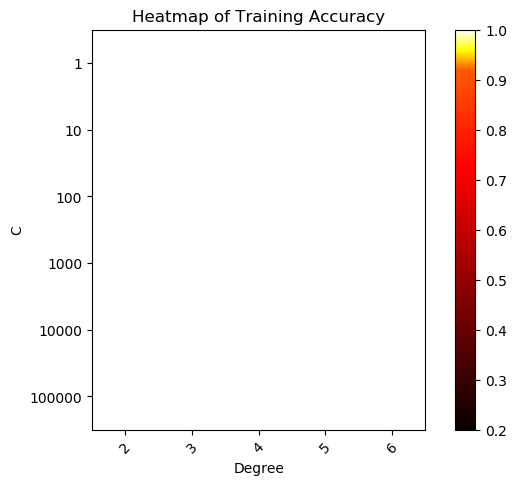

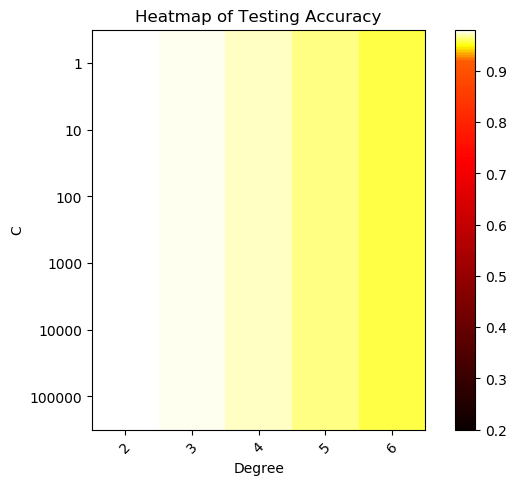

In [39]:
SVM_Models.heatmap(model.df['train_acc'], degrees, costs, 'Heatmap of Training Accuracy')
SVM_Models.heatmap(model.df['test_acc'], degrees, costs, 'Heatmap of Testing Accuracy')

The entire training accuracies are 1 because the maximum iteration of the model is infinity, this is weird, however, that is how the SVC polynomial was designed. Thus, the heatmap for training accuracy is all white. Mostly importantly, the SVM parameter cost did not affect the accuracy, again this is alarming. Could it be that the training set is linearly separable in higher dimensional? To answer this question a THOROUGH understanding of SVC package in Sklearn is required.

One of the highest testing accuracy (at index 0 on the table above) is 0.9806 with C=1 and degree=2, this seems to be the best model. As the degree increases the testing accuracy reduces, hence variance increases as the degree increase.

From the heatmaps, it can be shown that if the parameter degree 2 tends to produce good balanced between bias and variance. Also, cost doesn't affect the accuracy. The best parameters are degree 2 and cost 1.

### Performance of LinearSVC, RBF SVC vs. Polynomial SVC

The performance of the RBF SVC outperformed that of LinearSVC and  polynomial SVC. However, taking into account the training time, the LinearSVC is the fastest, although the polynomial SVC is faster than RBF SVC. Since training is only done once and the support vectors are the key attributes for prediction, then the polynomial basis SVC might be given higher consideration.

# (ii) Interpreting outputs n_support_ and dual_coef_ of the best model

Note: These have been explain in RBF SVC session.

In this case, there is a total of 8652 support vectors, models involving class 1 has the least number of support vectors of 423. This can be attributed to the fact that class 1 is more easier to be separated compared to other classes. Class 8 has the highest number of support vectors 1186, thus, it can be assumed that class 8 requires complex modeling, a similar pattern was seen in RBF SVC.

dualcoef has a shape of [n_class - 1, n_support_vector], thus the dualcoef for the best model is [9, 8652]. Hence, there are coefficients for SVs of class 0, coefficients for SVs of class 1, ... , coefficients for SVs of class 9 in the dualcoef.

In [18]:
best_model = model.model_param[0]

In [19]:
n_supp = best_model.n_support_
sup_vec = best_model.support_
dual = best_model.dual_coef_

### Support Vectors For First Positive Class

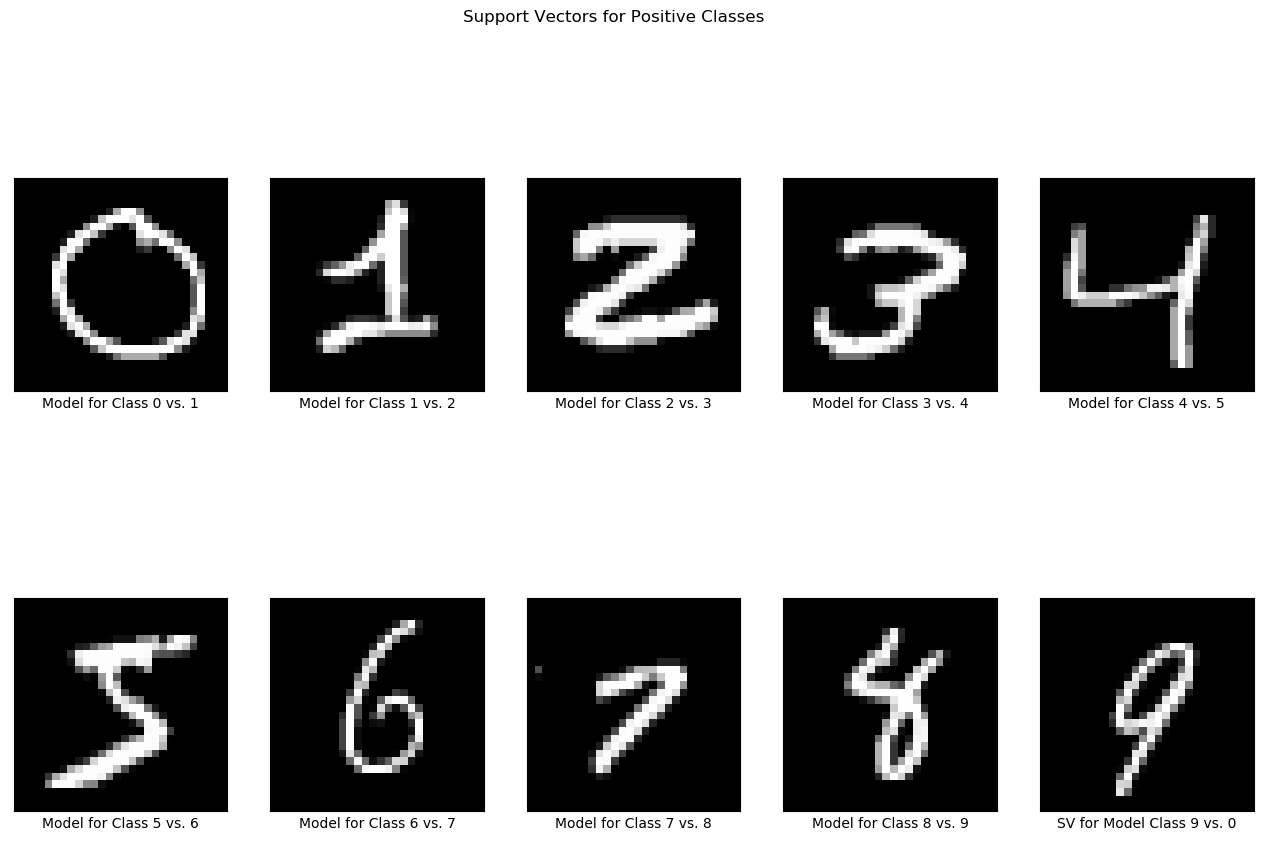

In [32]:
SVM_Models.plot_support(n_supp, sup_vec, util.train)

The images above represent one of the support vectors of each of the 'one-against-one' classifiers. For example, the first image is one of the support vectors of model class 0 vs. 1, this produces an image of digit 0 because it is positively classified.

### Support Vectors For First Negative Class

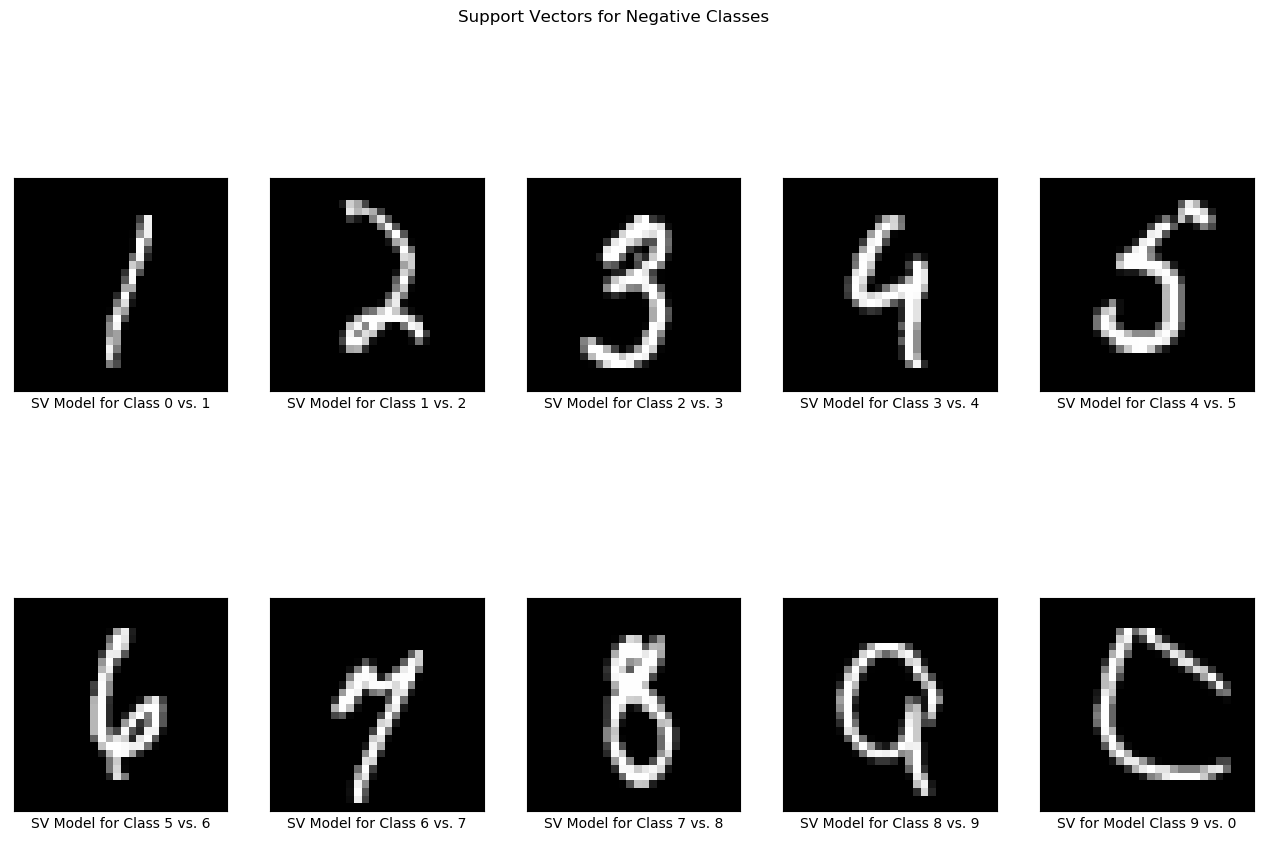

In [33]:
SVM_Models.plot_support_neg(n_supp, sup_vec, util.train)

Also, the images above represent one of the support vectors of each of the 'one-against-one' classifiers. For example, the first image is one of the support vectors of model class 0 vs. 1, this produces an image of digit 1 because it is negatively classified.

[1] http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html